In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'NOK=X'
numbers_in_currency = 'NOK'
share_name = 'NHY.OL'

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date', 'real_date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares,real_date
0,2014-03-31,18282,-12287,5995,462,6476,0,9599,30597,0,...,0,0,6255,18330,3941,45191,-890,-585,2039,2014-04-25
1,2014-06-30,18272,-12526,5746,269,6617,0,10213,29799,0,...,0,0,6141,17684,4093,46106,1179,-705,2039,2014-07-25
2,2014-09-30,19698,-12970,6728,666,6045,0,10334,29750,0,...,0,0,5007,16500,4850,45159,1151,-871,2039,2014-10-25
3,2014-12-31,21656,-13697,7959,-166,9253,0,12642,35927,0,...,0,0,6039,19116,5128,52243,4386,-1133,2039,2015-02-14
4,2015-03-31,23290,-14662,8628,1071,7172,0,13392,38413,0,...,0,0,4239,19204,5722,51077,1095,-847,2041,2015-04-25


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
36,2023-03-31,2023-04-25,2029,48534,-31295,17239,1144,30873,28350,30216,...,9839,211395,25702,0,5899,42342,29615,102813,3704,-2633
37,2023-06-30,2023-07-25,2029,53630,-32109,21521,5056,22453,0,28808,...,10215,208506,0,0,5271,40393,29756,101633,10110,-3476
38,2023-09-30,2023-10-25,2029,44702,-30501,14201,-625,19105,0,27648,...,10823,205260,0,0,5764,41718,29944,102197,5088,-3200
39,2023-12-31,2024-02-14,2029,46754,-29633,17121,-2772,24618,0,25449,...,8447,206462,0,0,7111,43892,28978,105884,3130,-4329
40,2024-03-31,2024-04-22,2006,47545,-30025,17520,428,19622,28969,25291,...,8741,213133,26541,0,8169,42768,30996,101384,-80,-3078


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2023-03-31,2023-04-25,2029,48534,-31295,17239,1144,30873,28350,30216,...,211395,25702,0,5899,42342,29615,102813,3704,-2633,10.221379
37,2023-06-30,2023-07-25,2029,53630,-32109,21521,5056,22453,0,28808,...,208506,0,0,5271,40393,29756,101633,10110,-3476,10.699984
38,2023-09-30,2023-10-25,2029,44702,-30501,14201,-625,19105,0,27648,...,205260,0,0,5764,41718,29944,102197,5088,-3200,10.483742
39,2023-12-31,2024-02-14,2029,46754,-29633,17121,-2772,24618,0,25449,...,206462,0,0,7111,43892,28978,105884,3130,-4329,10.821103
40,2024-03-31,2024-04-22,2006,47545,-30025,17520,428,19622,28969,25291,...,213133,26541,0,8169,42768,30996,101384,-80,-3078,10.502364


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2023-03-31,2023-04-25,2029,48534,-31295,17239,1144,30873,28350,30216,...,211395,25702,0,5899,42342,29615,102813,3704,-2633,10.221379
37,2023-06-30,2023-07-25,2029,53630,-32109,21521,5056,22453,0,28808,...,208506,0,0,5271,40393,29756,101633,10110,-3476,10.699984
38,2023-09-30,2023-10-25,2029,44702,-30501,14201,-625,19105,0,27648,...,205260,0,0,5764,41718,29944,102197,5088,-3200,10.483742
39,2023-12-31,2024-02-14,2029,46754,-29633,17121,-2772,24618,0,25449,...,206462,0,0,7111,43892,28978,105884,3130,-4329,10.821103
40,2024-03-31,2024-04-22,2006,47545,-30025,17520,428,19622,28969,25291,...,213133,26541,0,8169,42768,30996,101384,-80,-3078,10.502364


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2014-04-28,22.507479,2014-03-31,18282.0,0.906327,34.591957,2039.0,-1220.0,-0.598333,6476.0,...,0.609493,0.390507,inf,inf,11.292156,5.120117,0.327918,0.025271,0.015969,0.026201
1,2014-05-05,22.015360,2014-03-31,18282.0,0.906327,34.591957,2039.0,-1220.0,-0.598333,6476.0,...,0.609493,0.390507,inf,inf,11.292156,5.120117,0.327918,0.025271,0.015969,0.026201
2,2014-05-12,22.705647,2014-03-31,18282.0,0.906327,34.591957,2039.0,-1220.0,-0.598333,6476.0,...,0.609493,0.390507,inf,inf,11.292156,5.120117,0.327918,0.025271,0.015969,0.026201
3,2014-05-19,23.041506,2014-03-31,18282.0,0.906327,34.591957,2039.0,-1220.0,-0.598333,6476.0,...,0.609493,0.390507,inf,inf,11.292156,5.120117,0.327918,0.025271,0.015969,0.026201
4,2014-05-26,22.740629,2014-03-31,18282.0,0.906327,34.591957,2039.0,-1220.0,-0.598333,6476.0,...,0.609493,0.390507,inf,inf,11.292156,5.120117,0.327918,0.025271,0.015969,0.026201


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2014-04-28,22.507479,2014-03-31,18282.0,0.906327,34.591957,2039.0,-1220.0,-0.598333,6476.0,...,5.120117,0.327918,0.025271,0.015969,0.026201,24.833739,0.650656,0.627567,1.156982,-37.617007
1,2014-05-05,22.015360,2014-03-31,18282.0,0.906327,34.591957,2039.0,-1220.0,-0.598333,6476.0,...,5.120117,0.327918,0.025271,0.015969,0.026201,24.290757,0.636430,0.613846,1.143260,-36.794524
2,2014-05-12,22.705647,2014-03-31,18282.0,0.906327,34.591957,2039.0,-1220.0,-0.598333,6476.0,...,5.120117,0.327918,0.025271,0.015969,0.026201,25.052388,0.656385,0.633093,1.162507,-37.948208
3,2014-05-19,23.041506,2014-03-31,18282.0,0.906327,34.591957,2039.0,-1220.0,-0.598333,6476.0,...,5.120117,0.327918,0.025271,0.015969,0.026201,25.422960,0.666094,0.642457,1.171872,-38.509533
4,2014-05-26,22.740629,2014-03-31,18282.0,0.906327,34.591957,2039.0,-1220.0,-0.598333,6476.0,...,5.120117,0.327918,0.025271,0.015969,0.026201,25.090986,0.657396,0.634068,1.163482,-38.006675


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

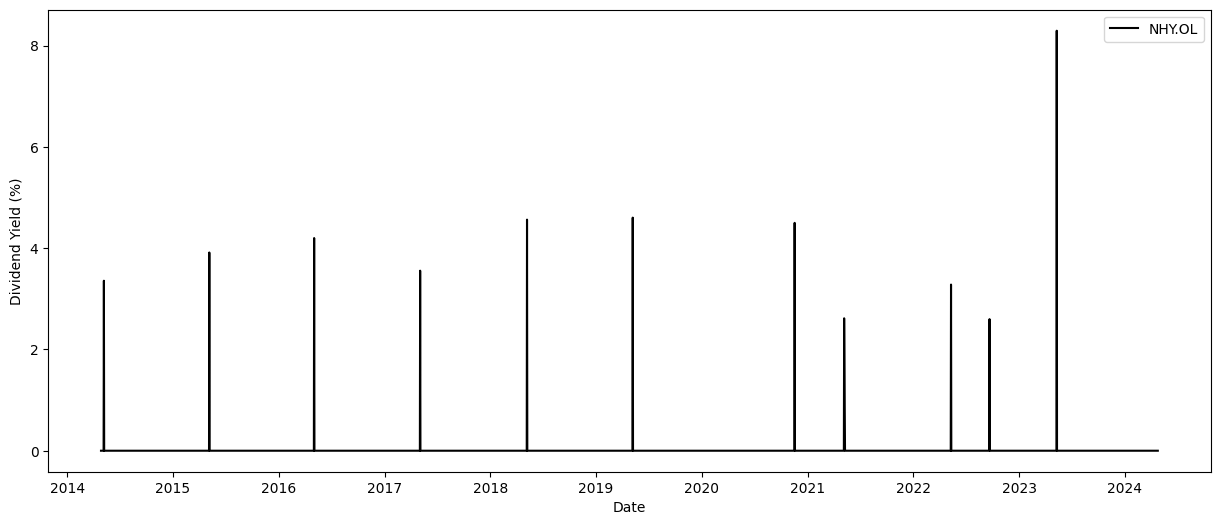

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate    0.562236
share_price      1.000000
Name: share_price, dtype: float64


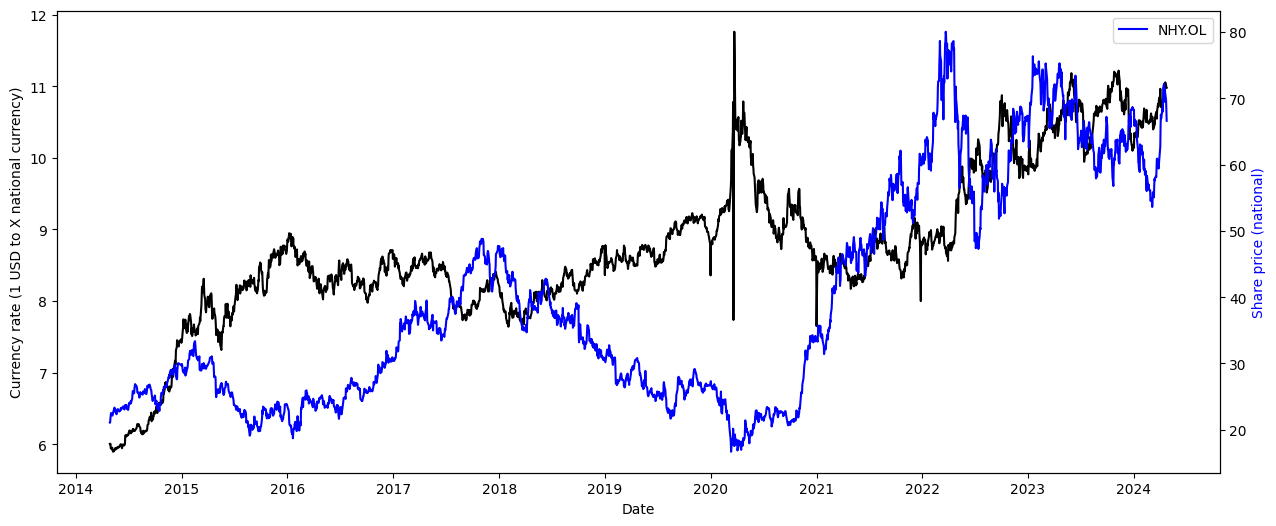

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

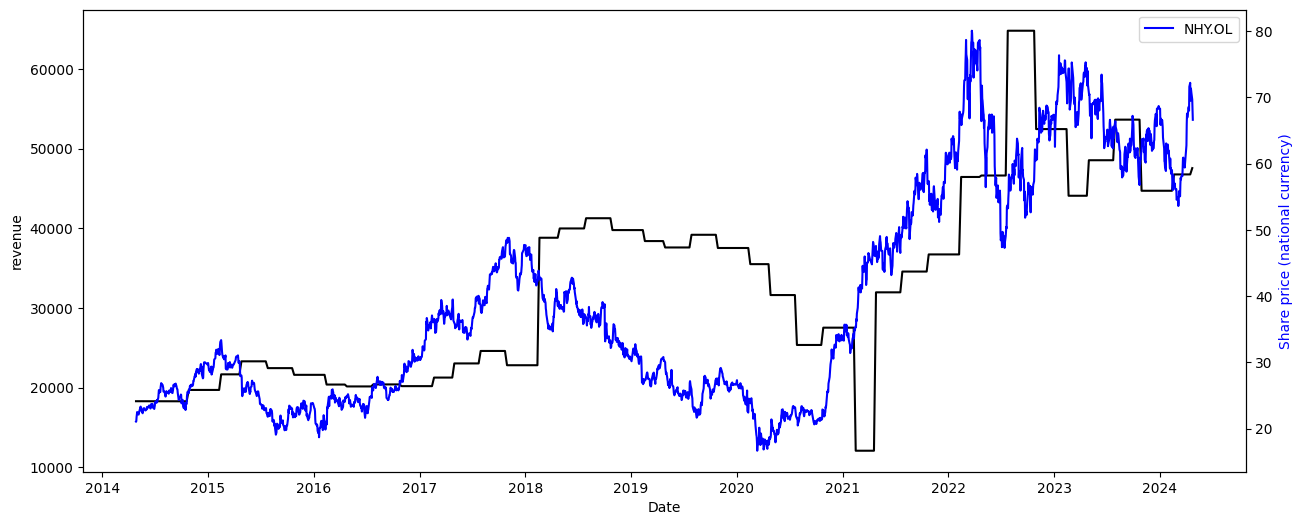

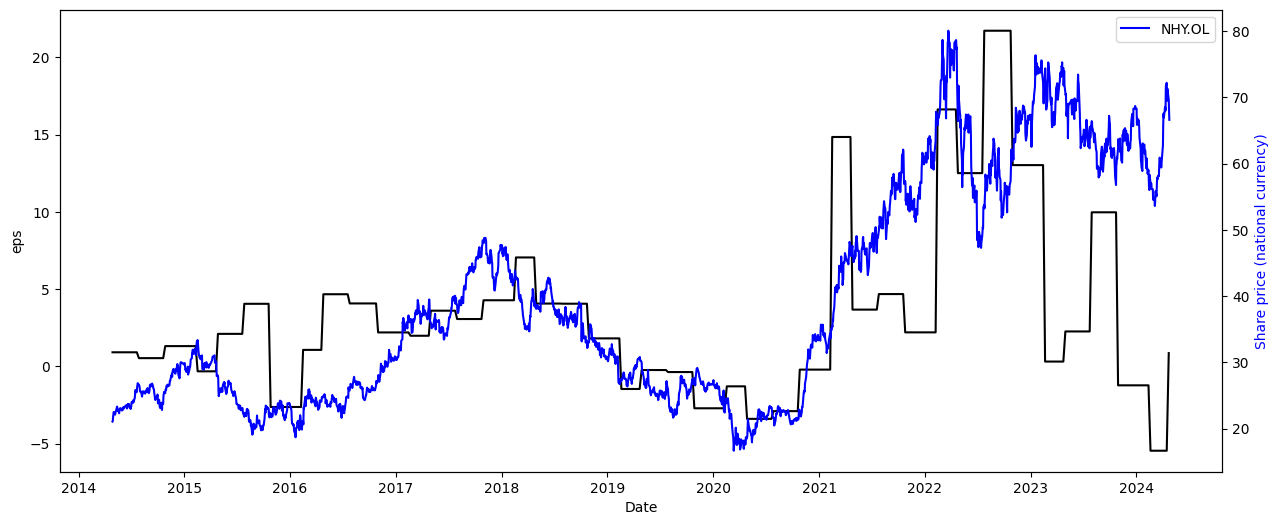

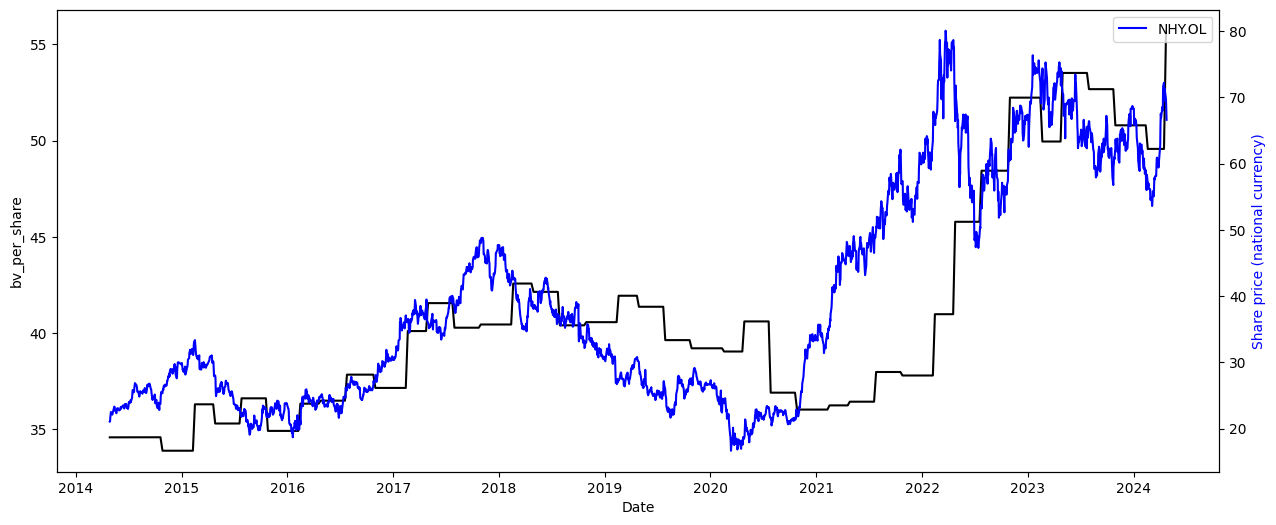

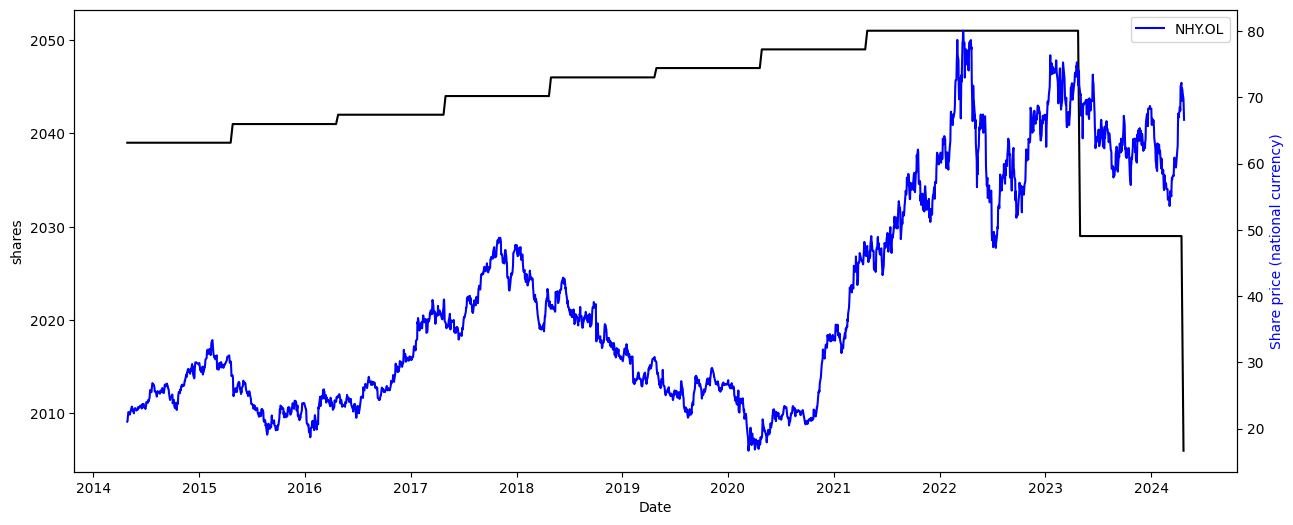

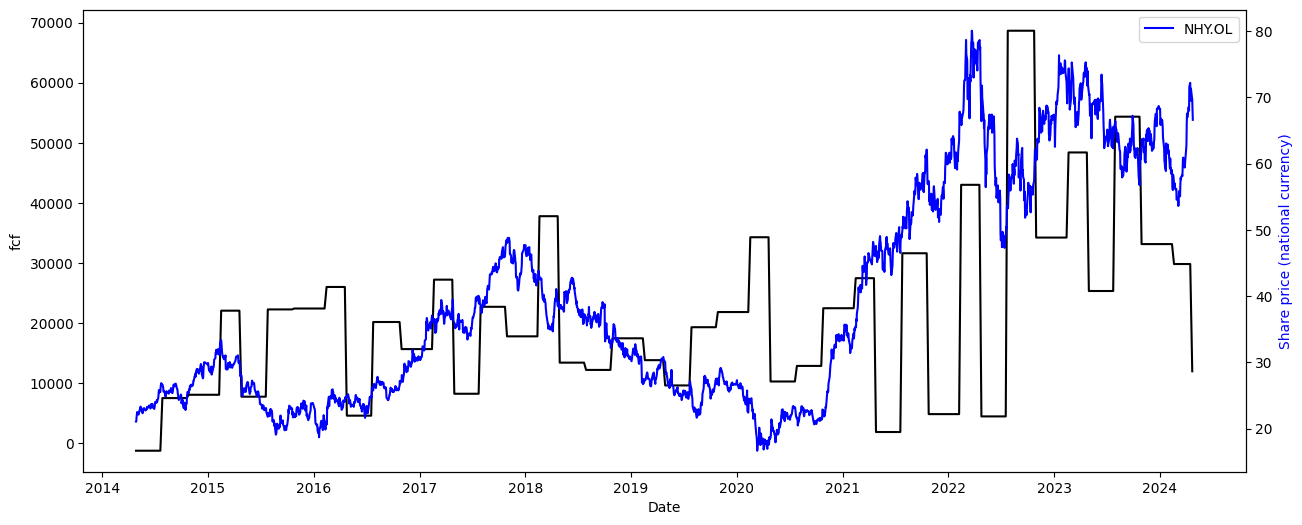

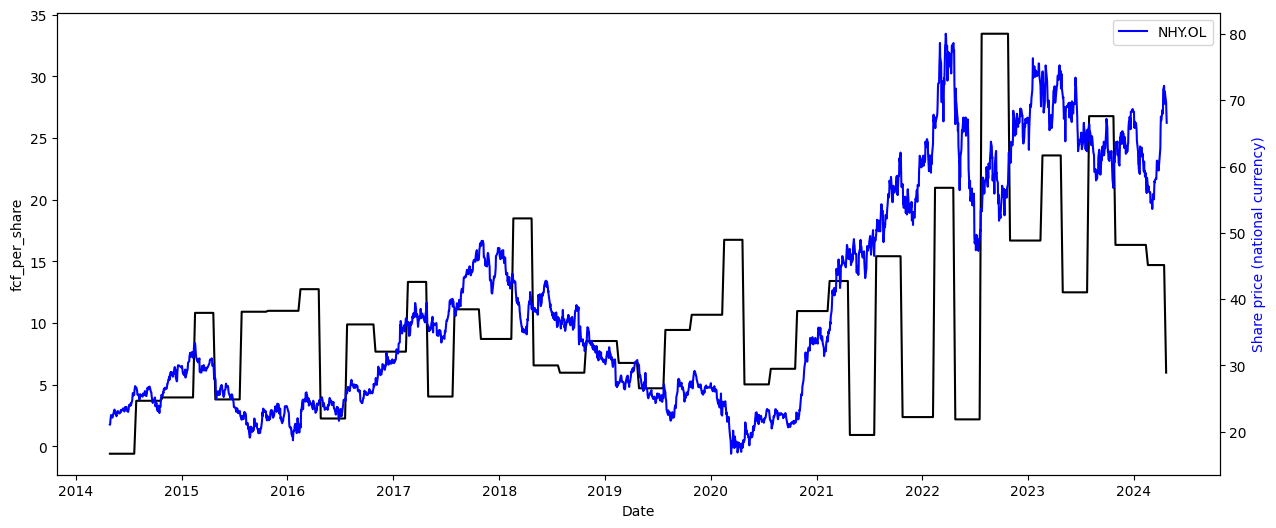

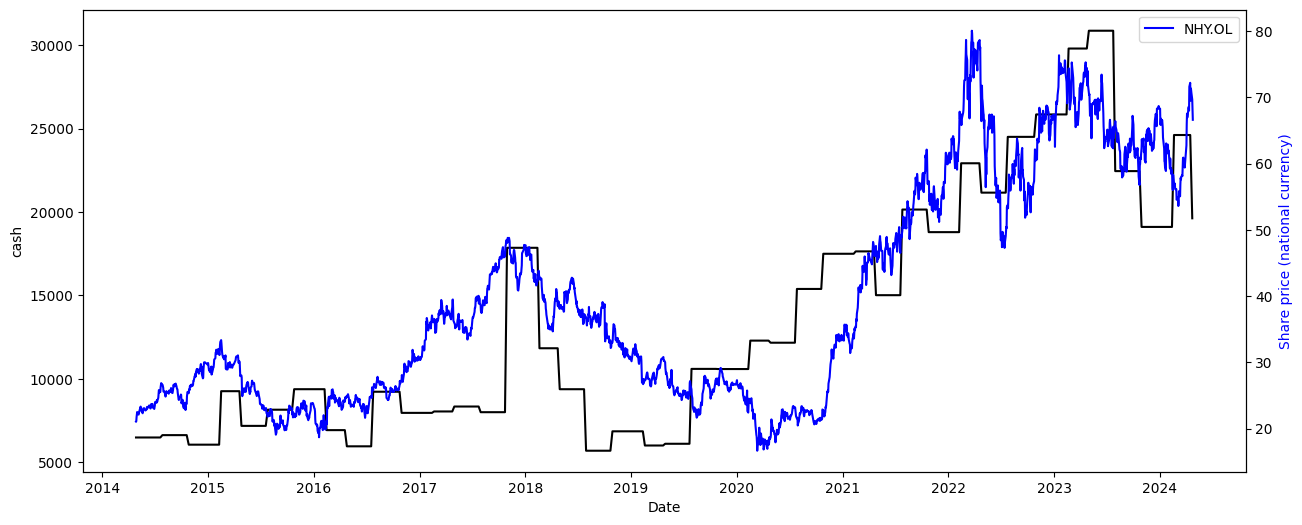

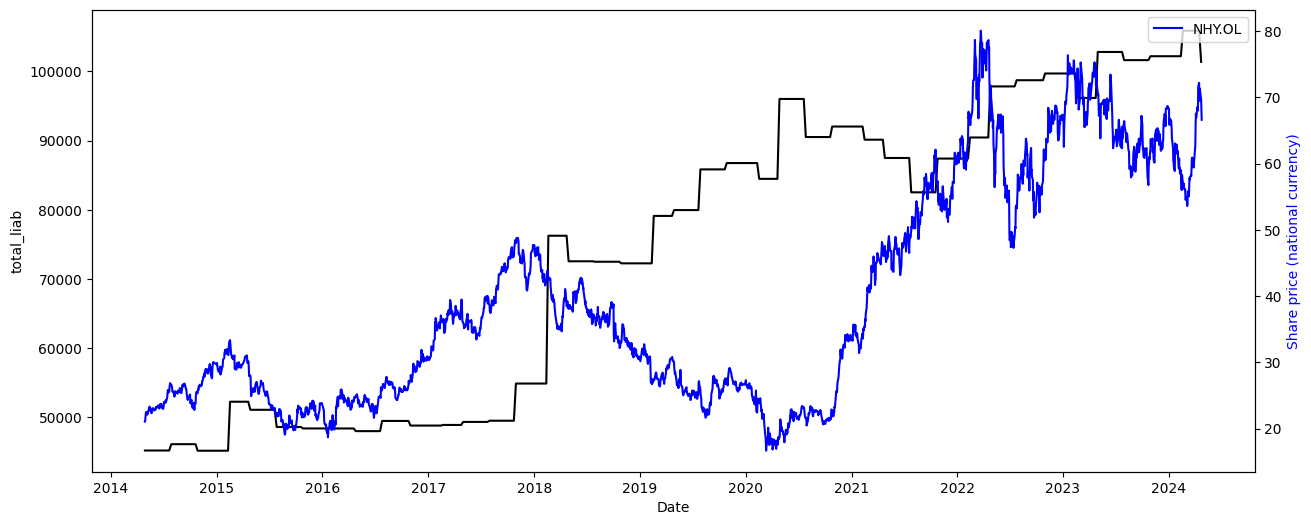

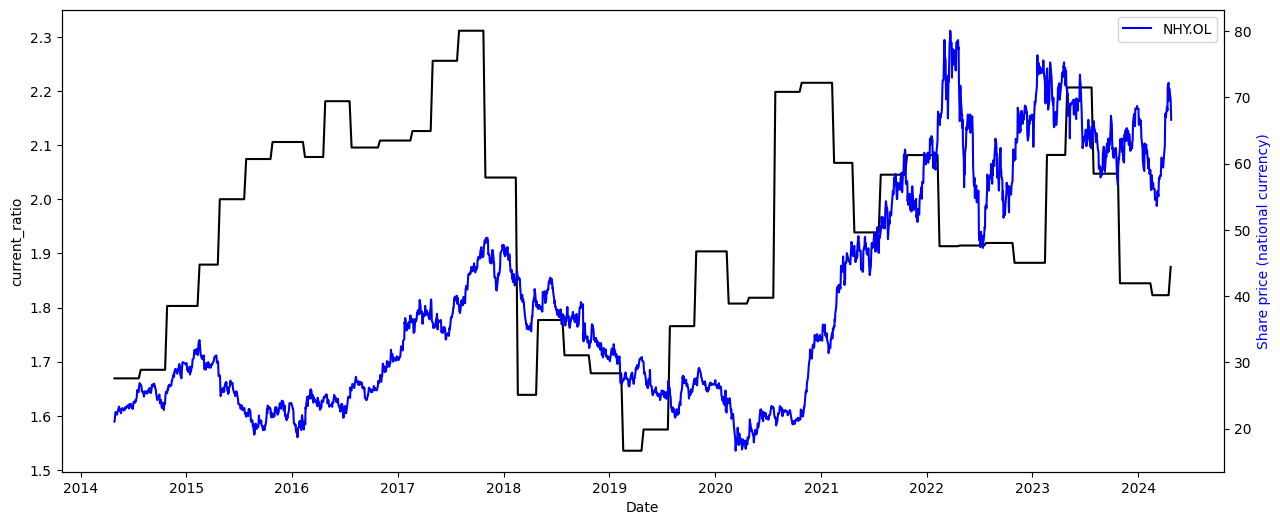

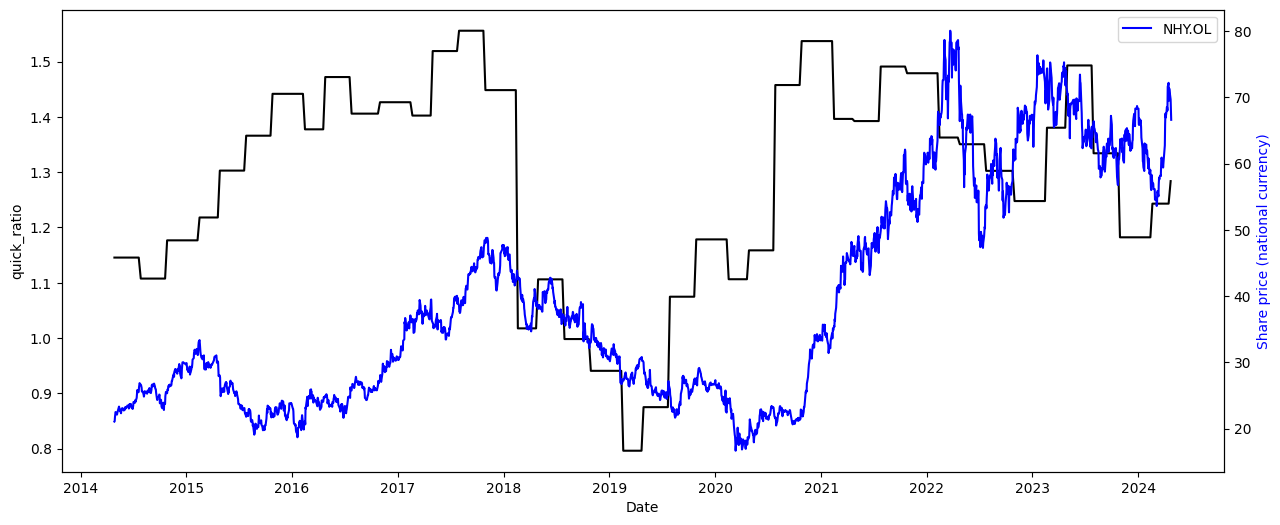

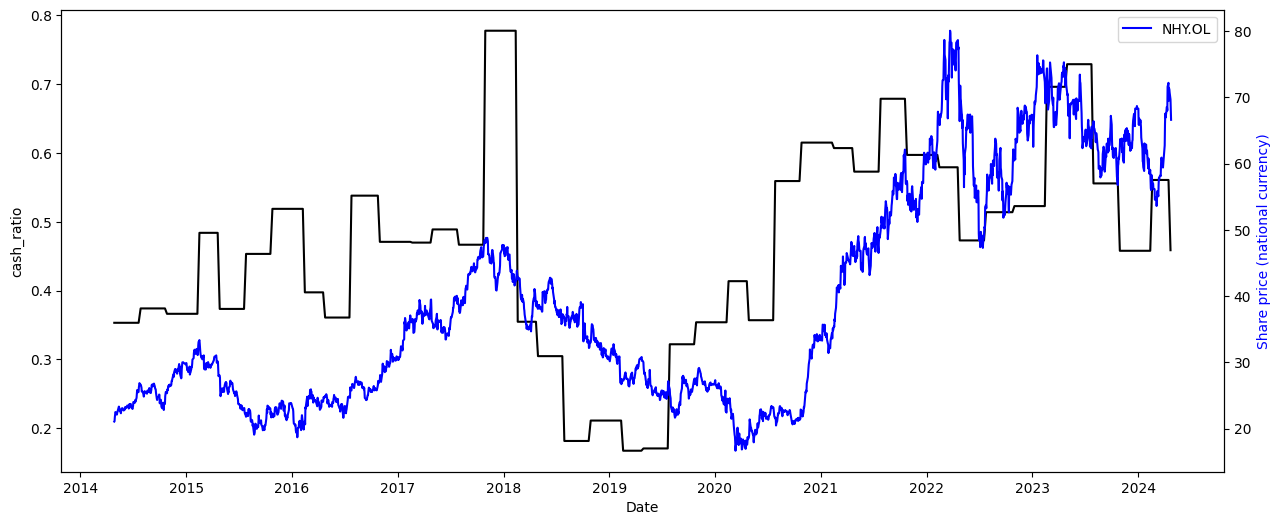

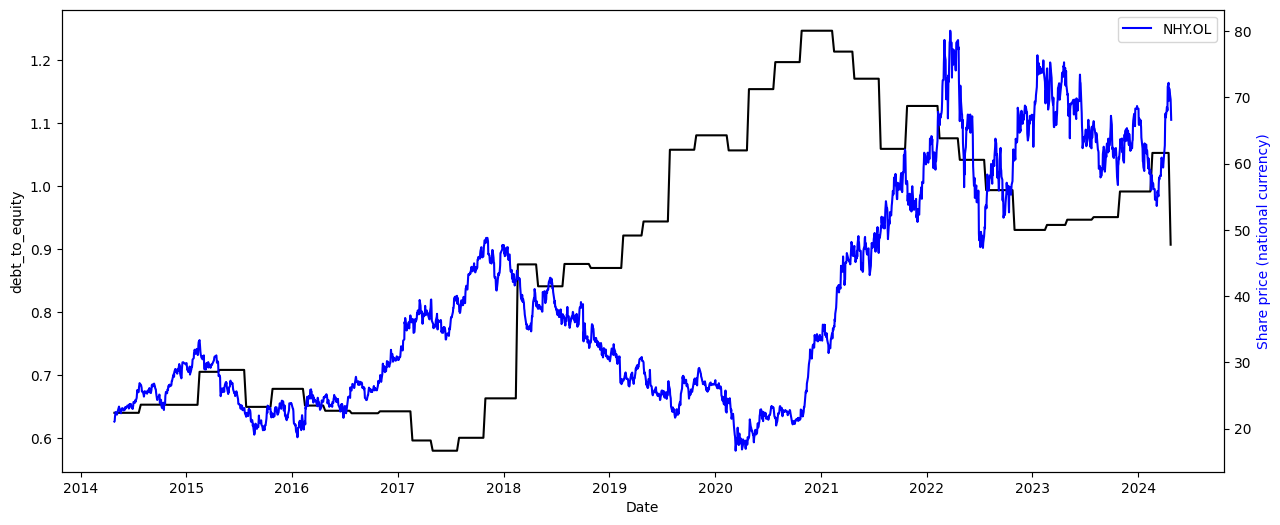

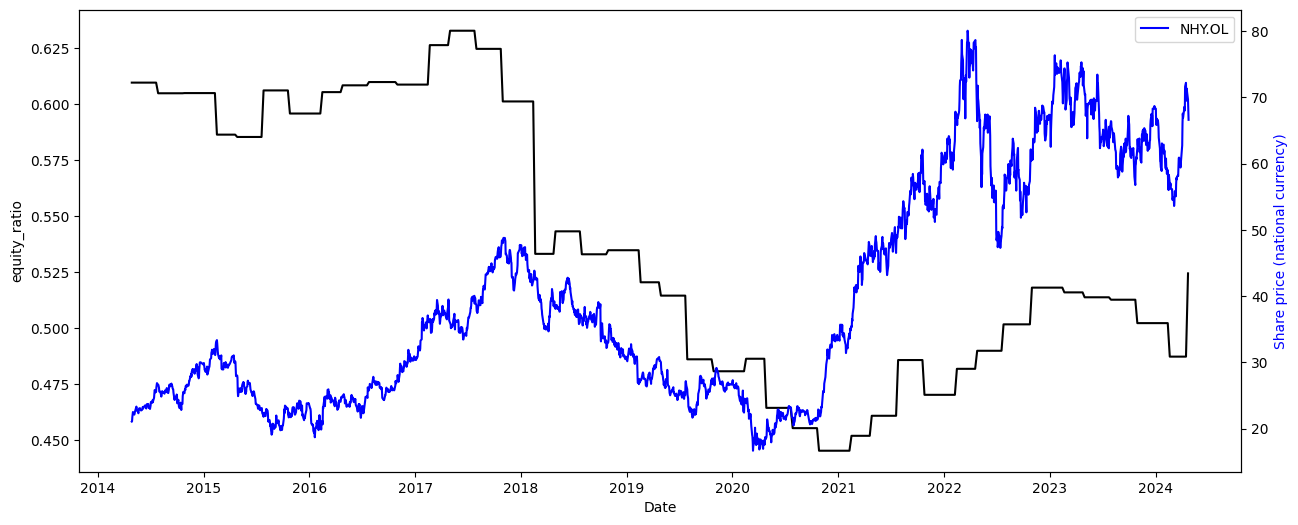

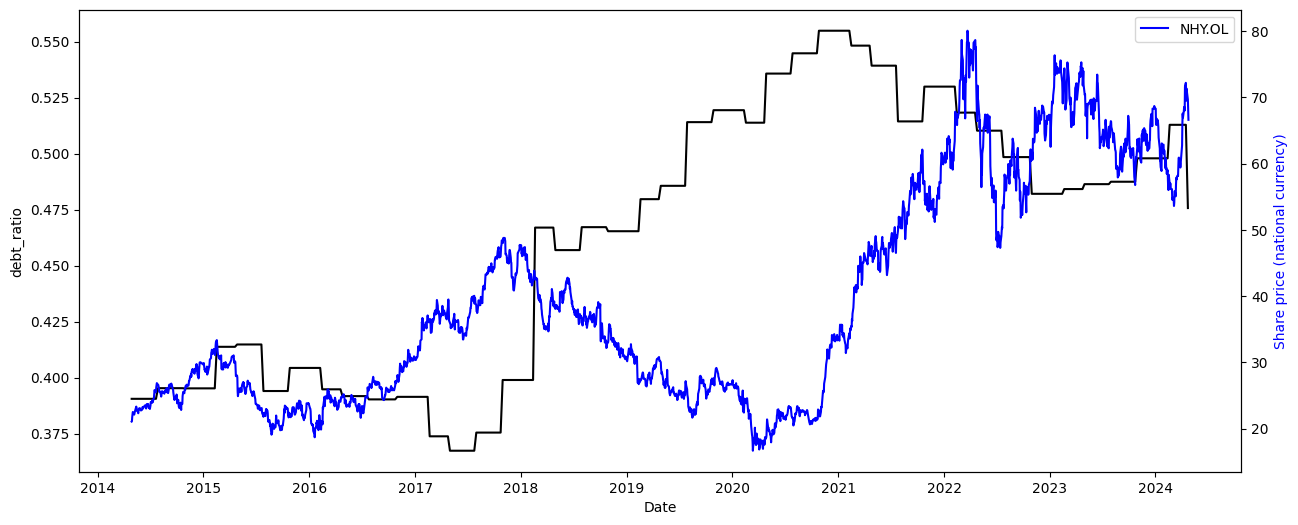

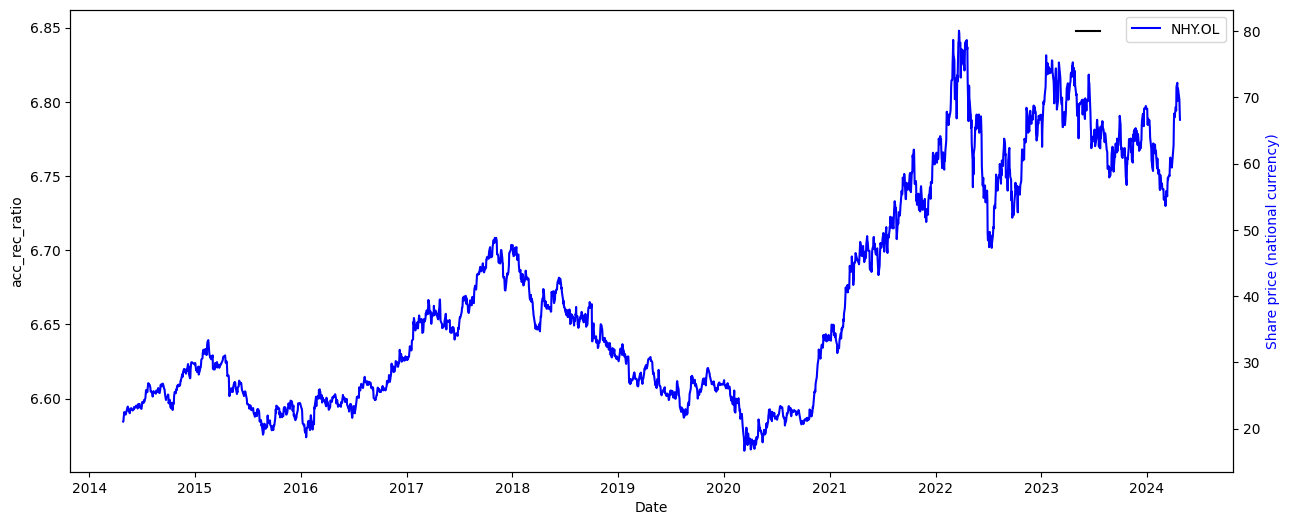

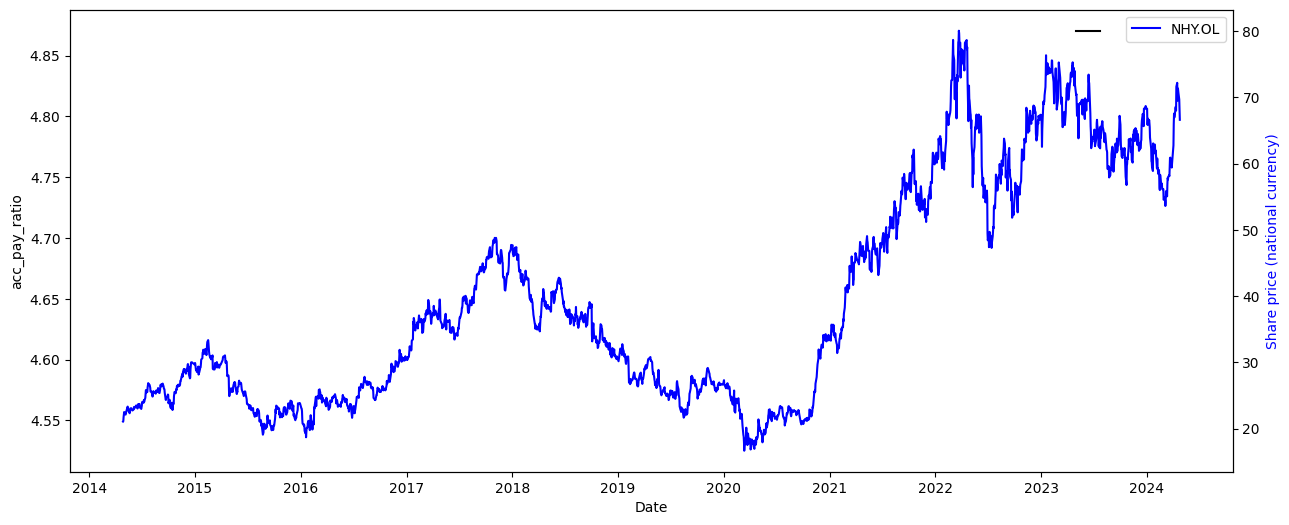

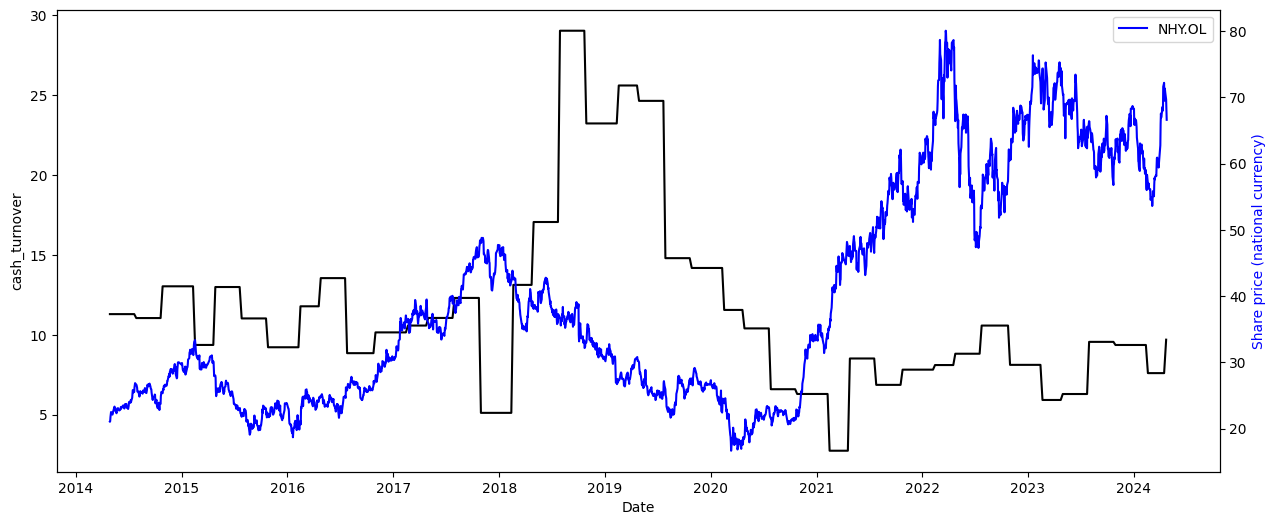

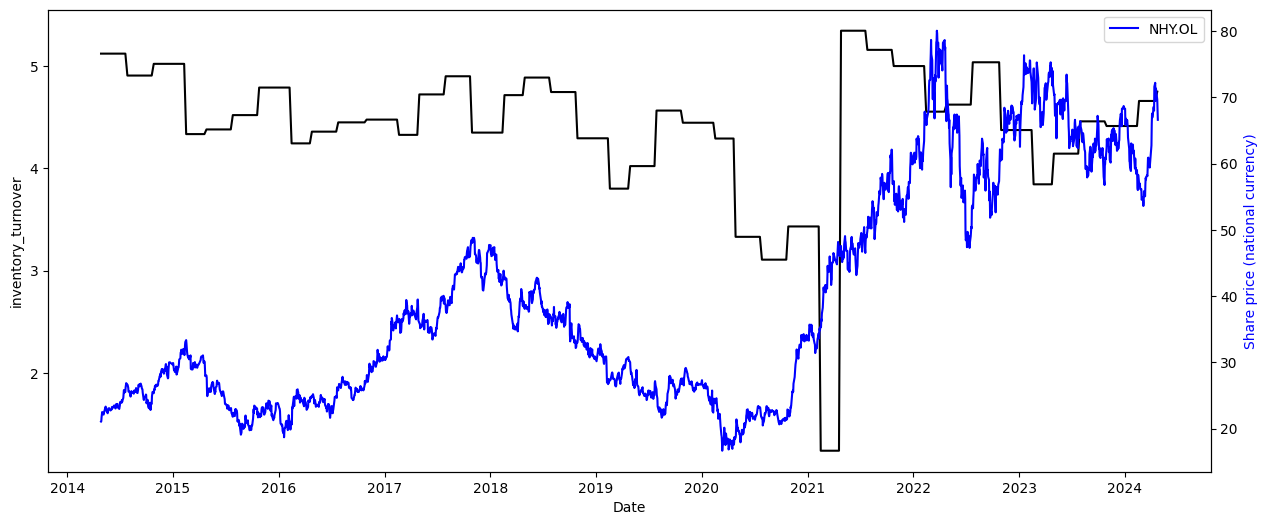

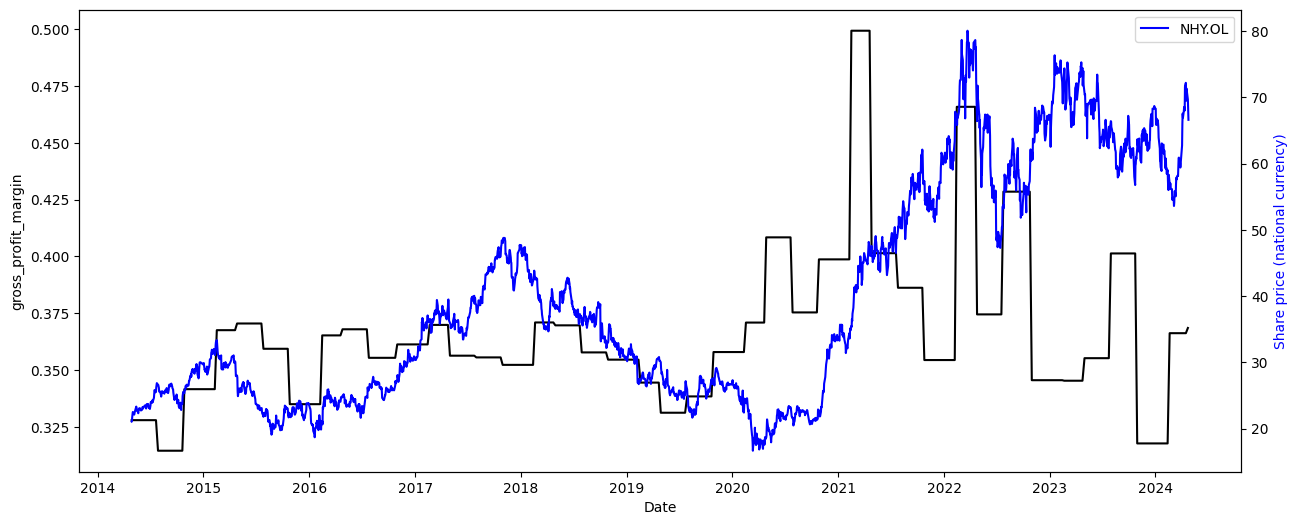

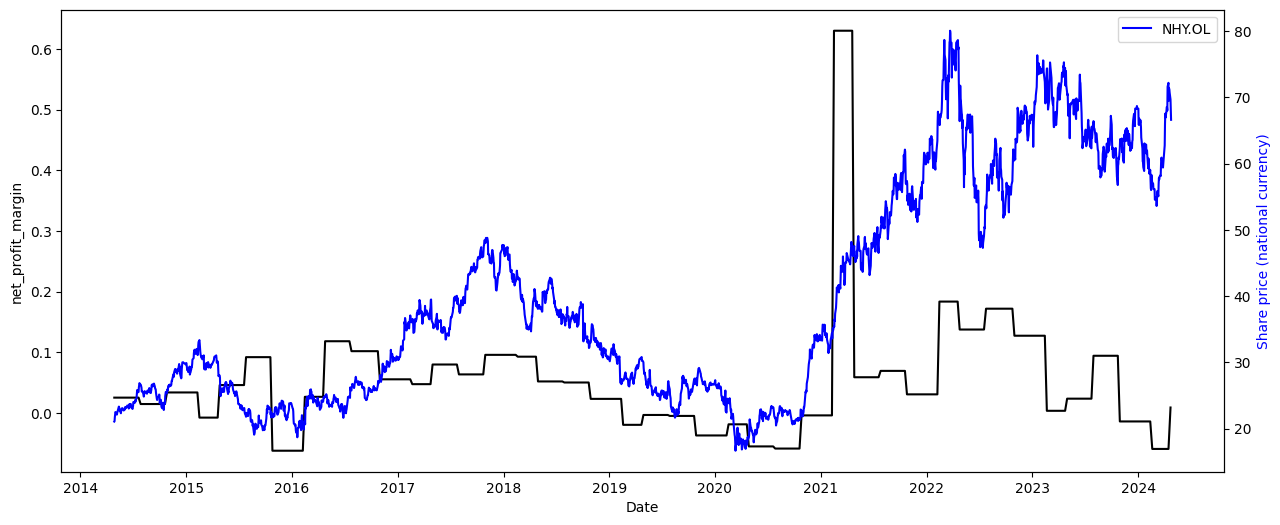

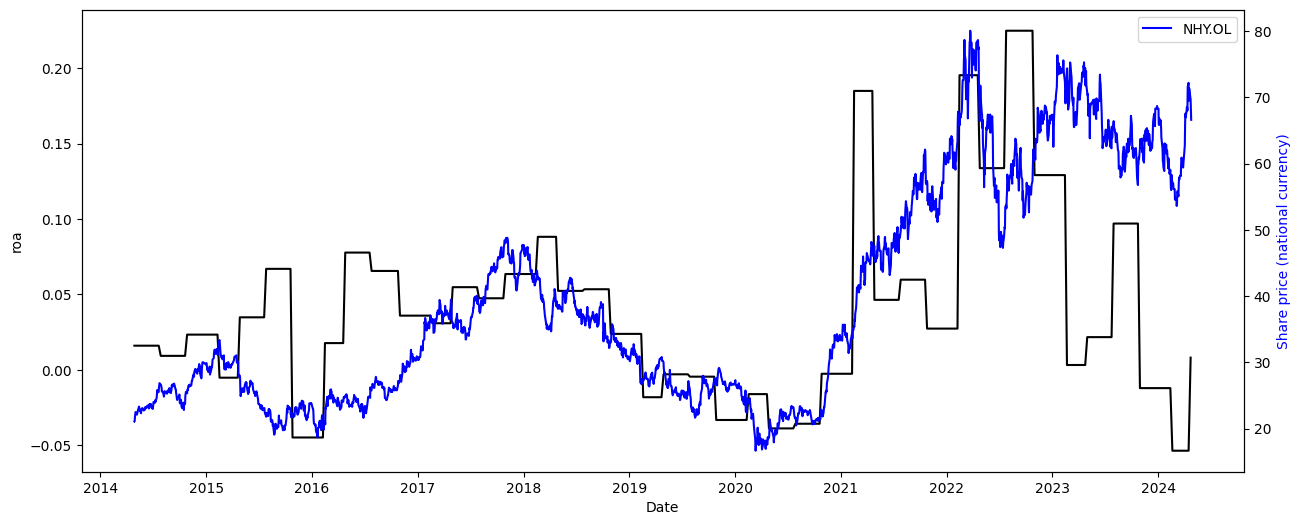

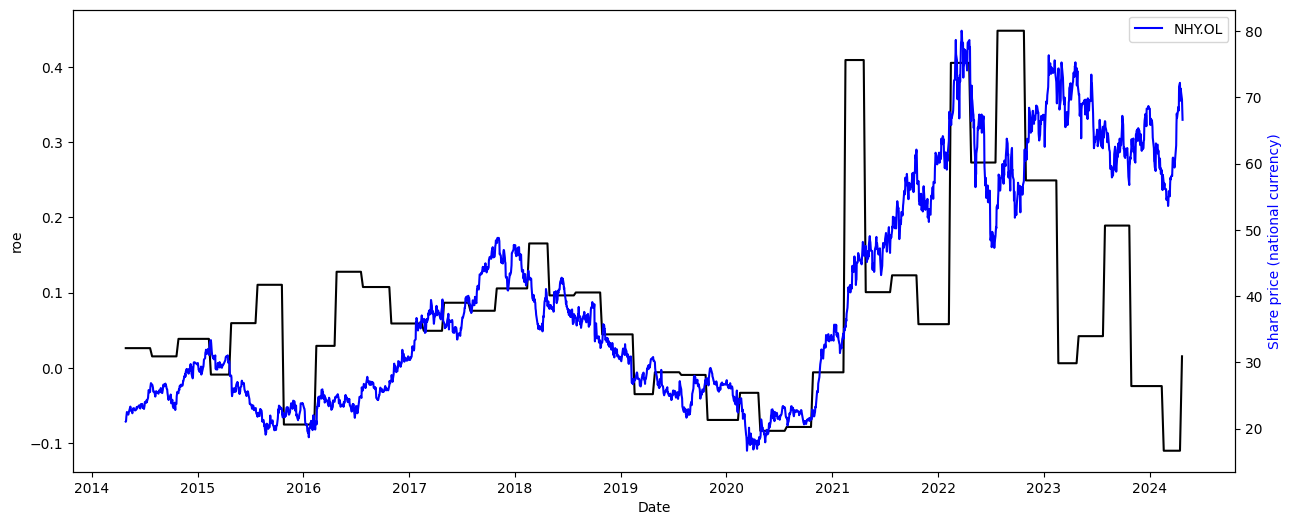

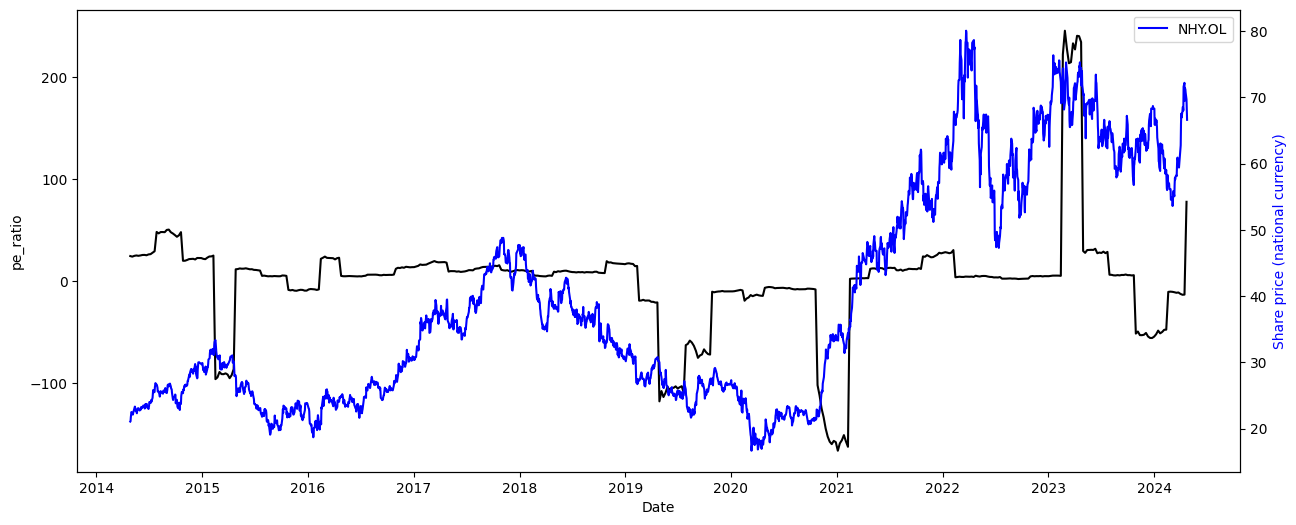

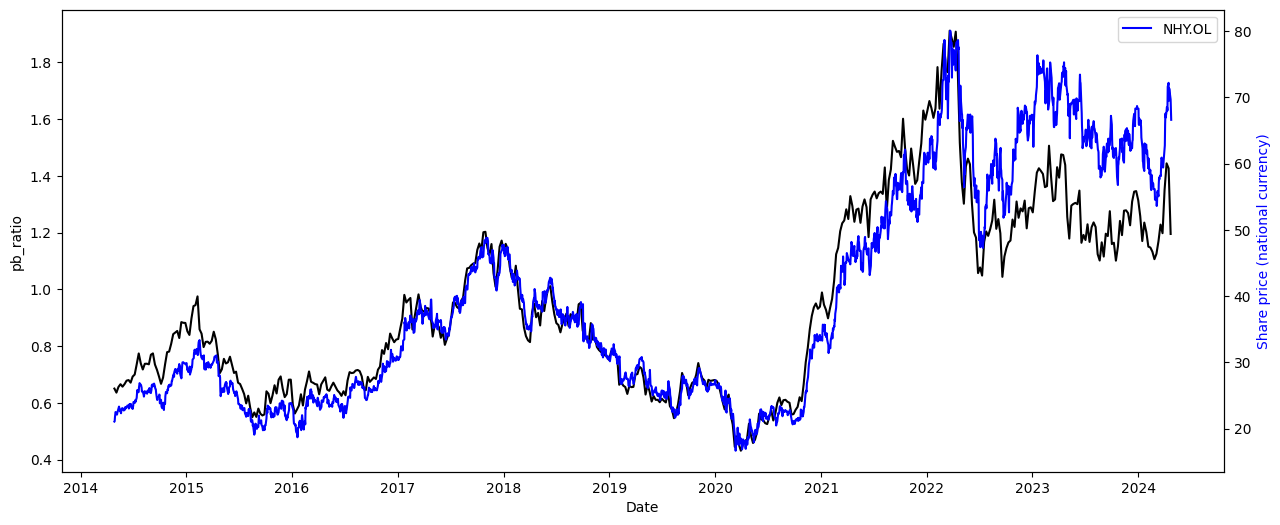

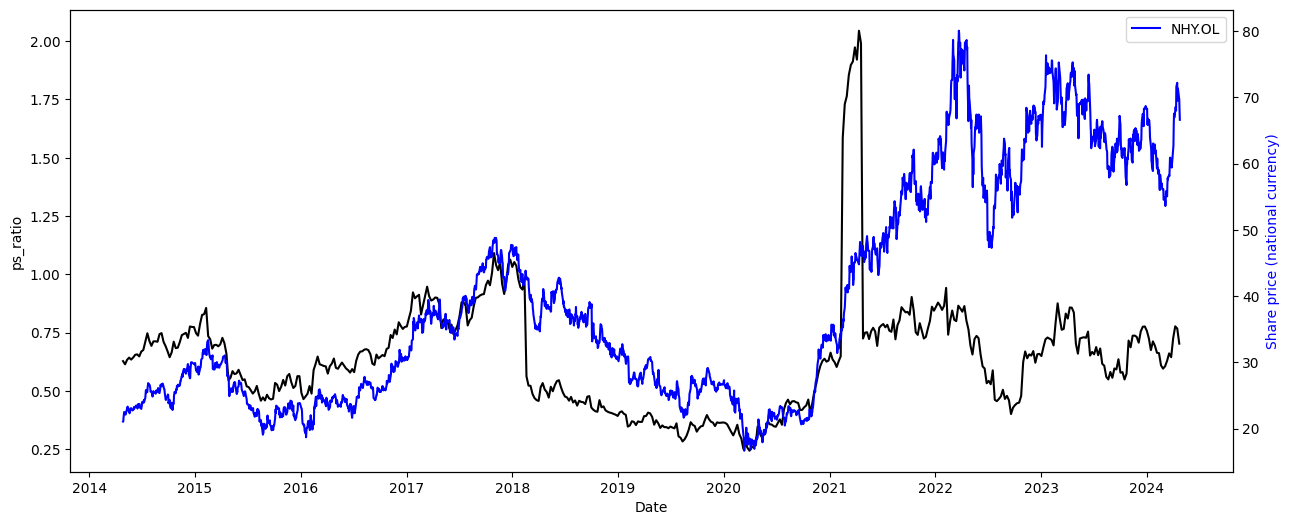

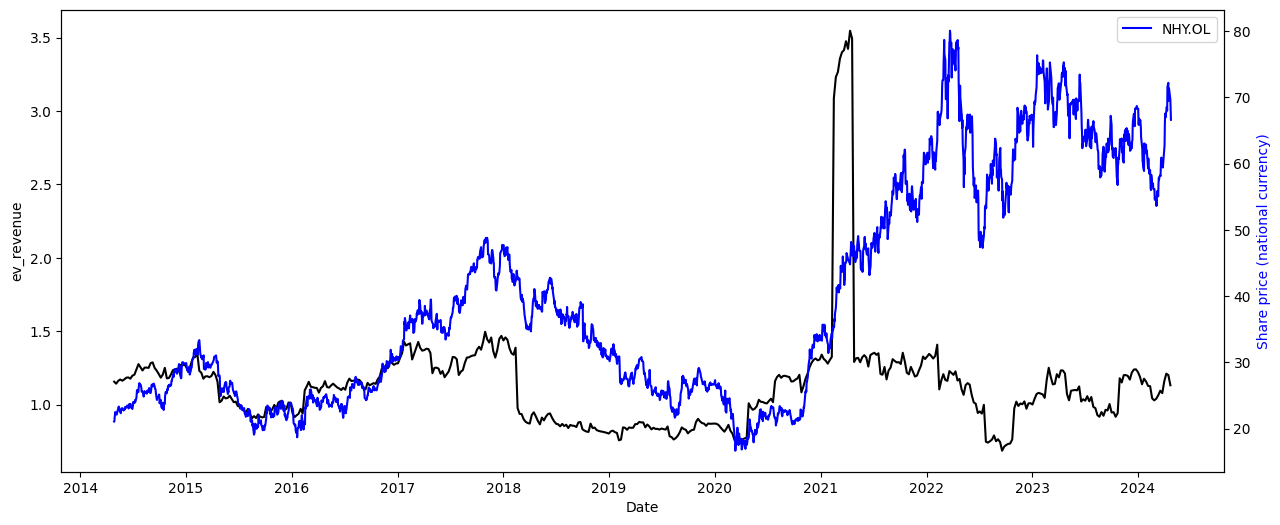

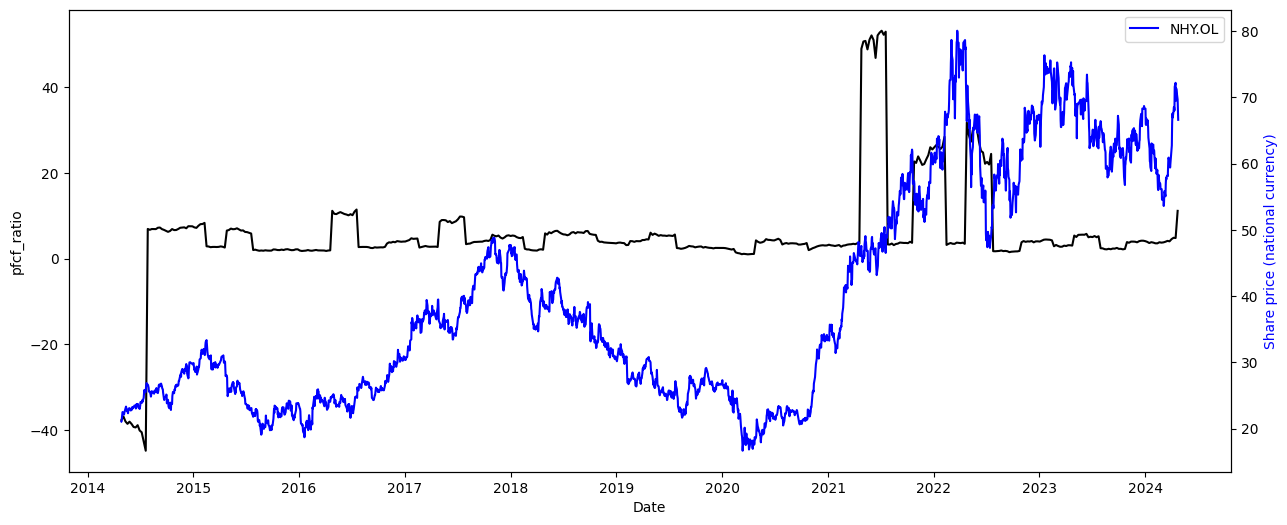

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

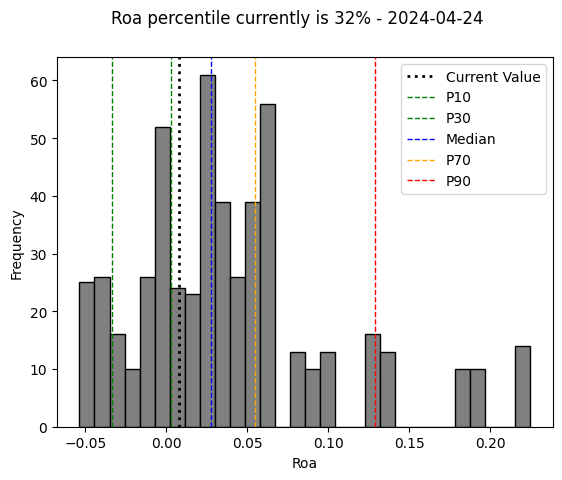

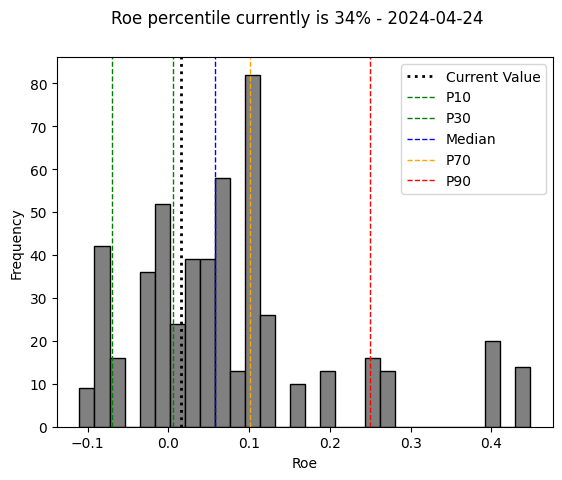

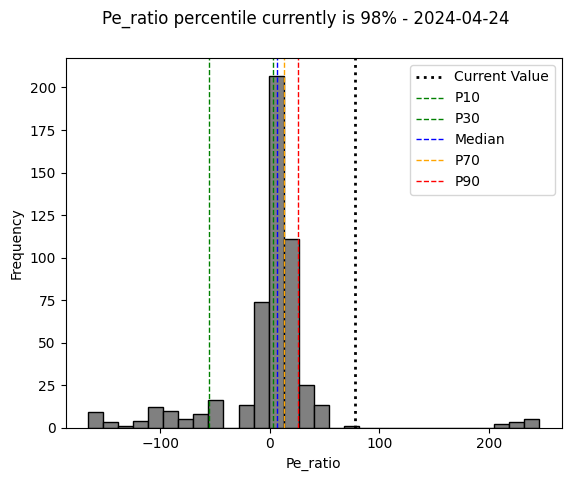

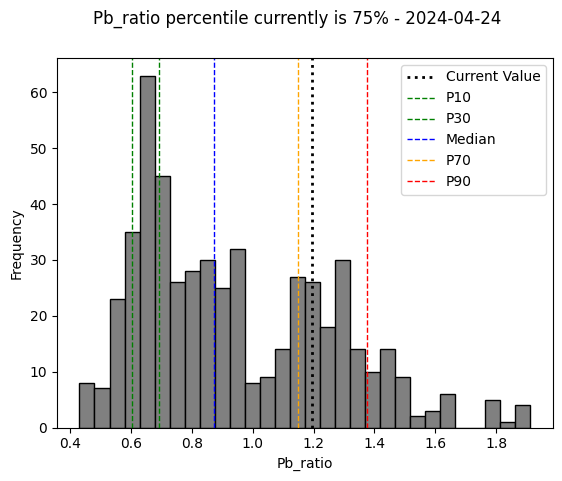

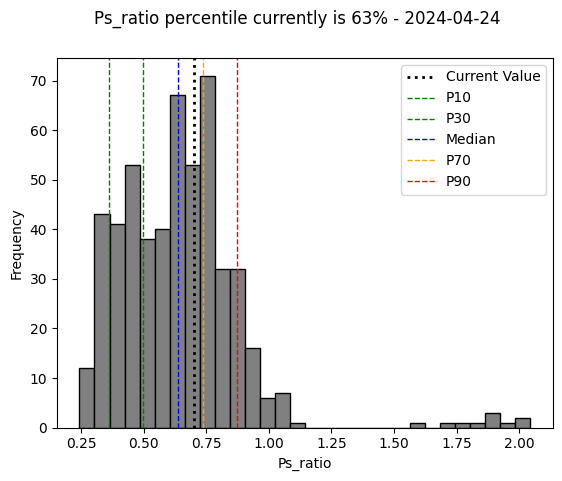

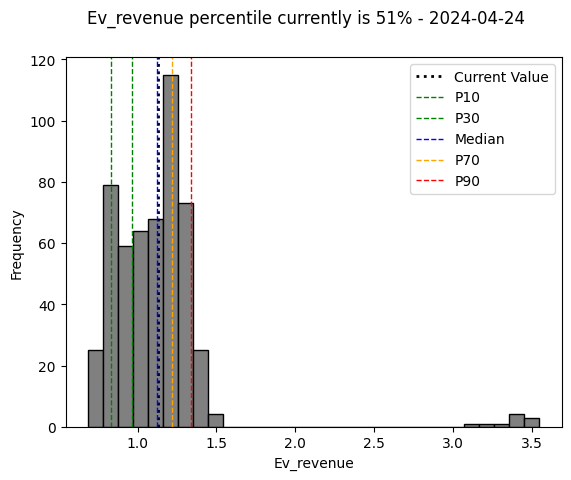

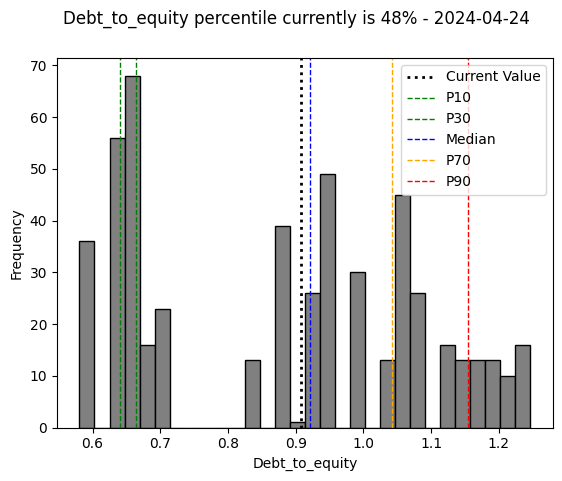

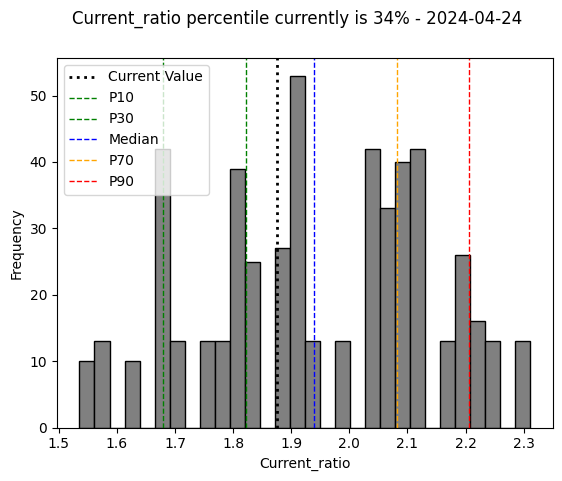

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.995811,0.160673,0.505217,0.385401,0.253151,0.005165,0.101370
roe,0.995811,1.000000,0.149695,0.530581,0.404551,0.285261,0.060646,0.081096
pe_ratio,0.160673,0.149695,1.000000,0.266364,0.243870,0.084705,-0.265272,0.112202
pb_ratio,0.505217,0.530581,0.266364,1.000000,0.536659,0.296390,0.325799,0.183159
ps_ratio,0.385401,0.404551,0.243870,0.536659,1.000000,0.918981,-0.091511,0.395617
ev_revenue,0.253151,0.285261,0.084705,0.296390,0.918981,1.000000,0.080151,0.332844
debt_to_equity,0.005165,0.060646,-0.265272,0.325799,-0.091511,0.080151,1.000000,-0.109907
current_ratio,0.101370,0.081096,0.112202,0.183159,0.395617,0.332844,-0.109907,1.000000


1 timestemos have been found!


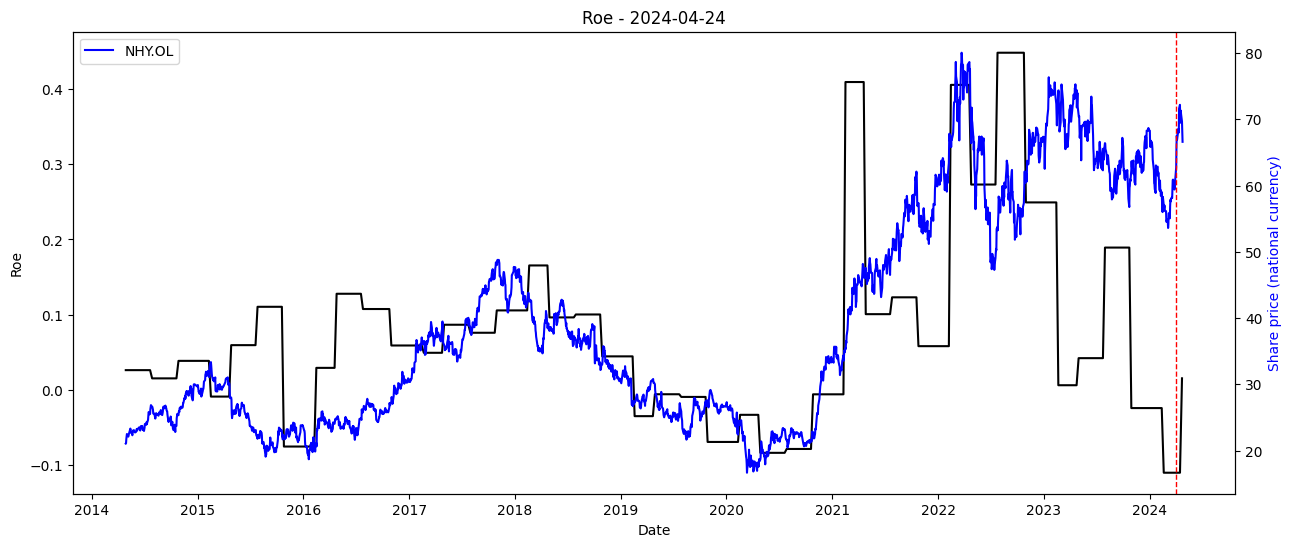

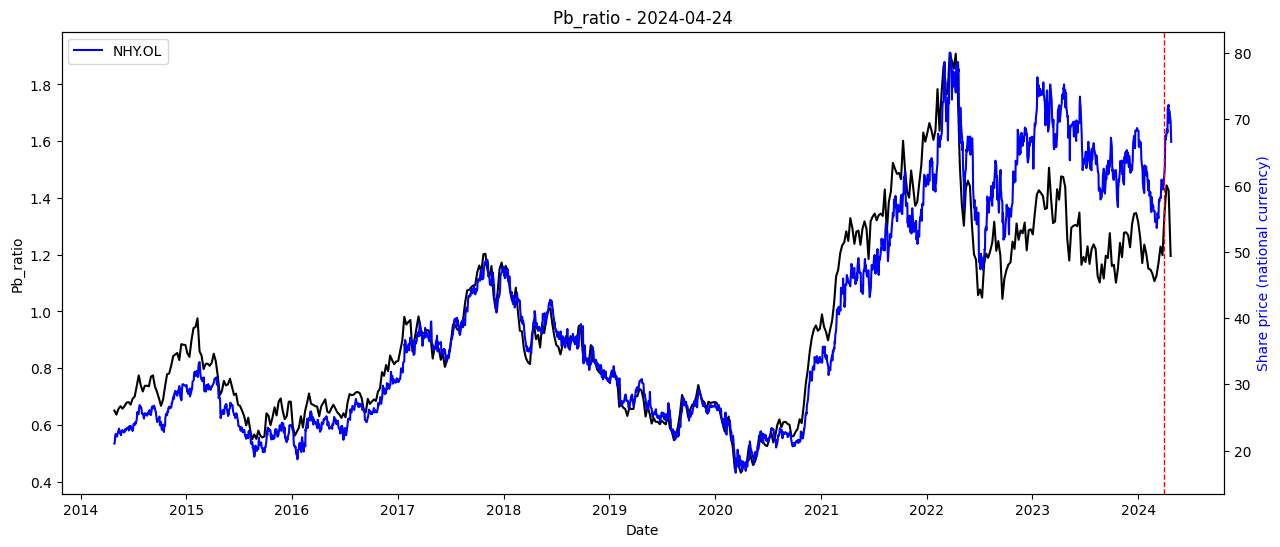

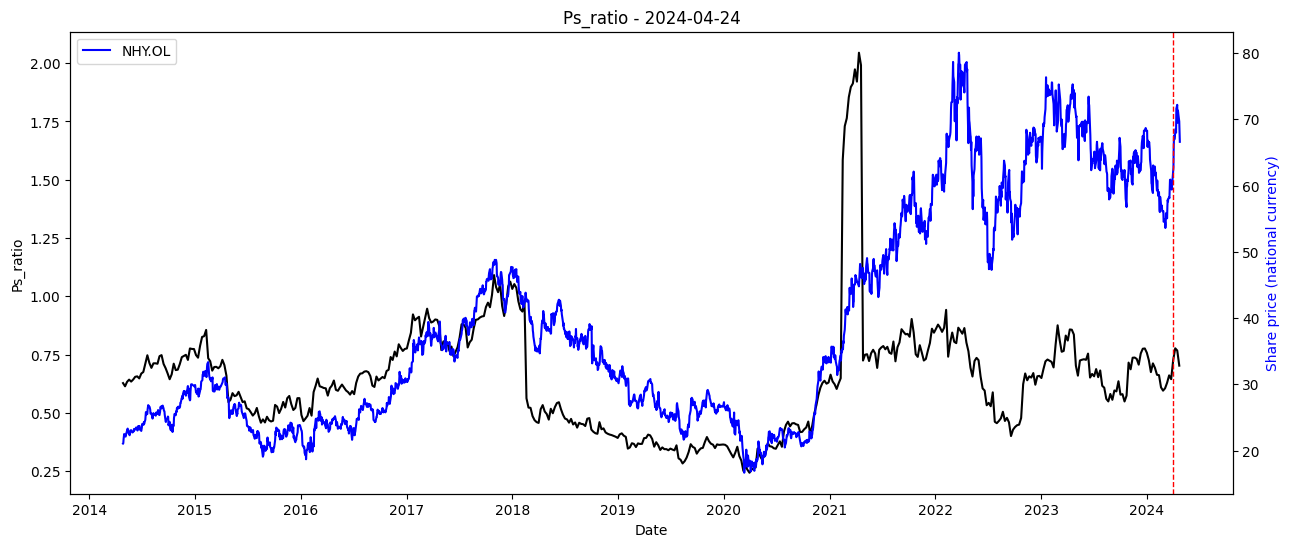

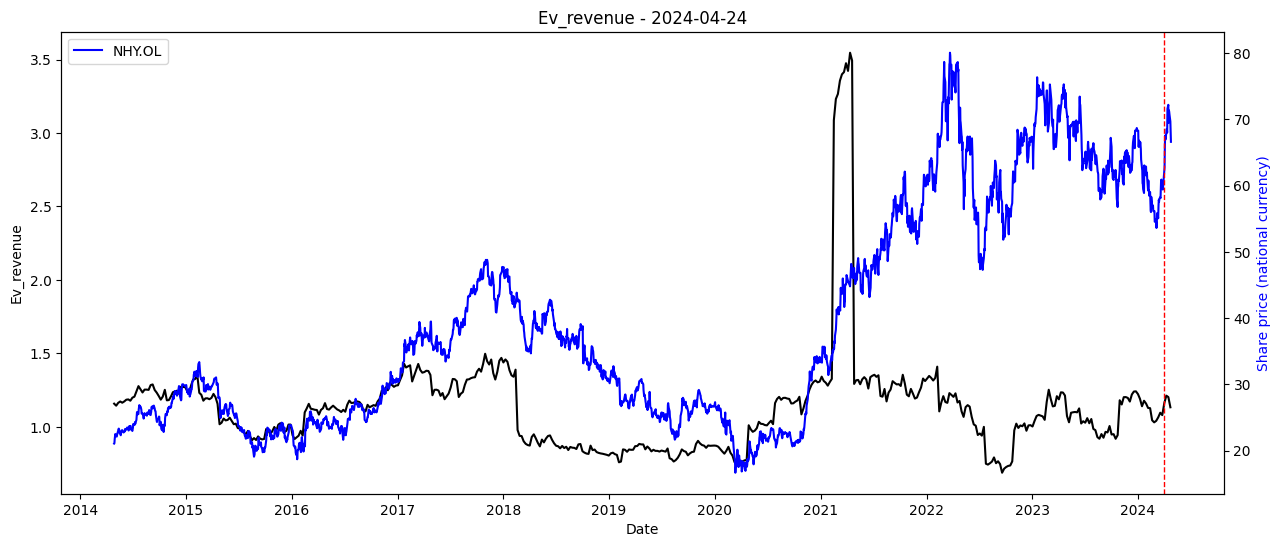

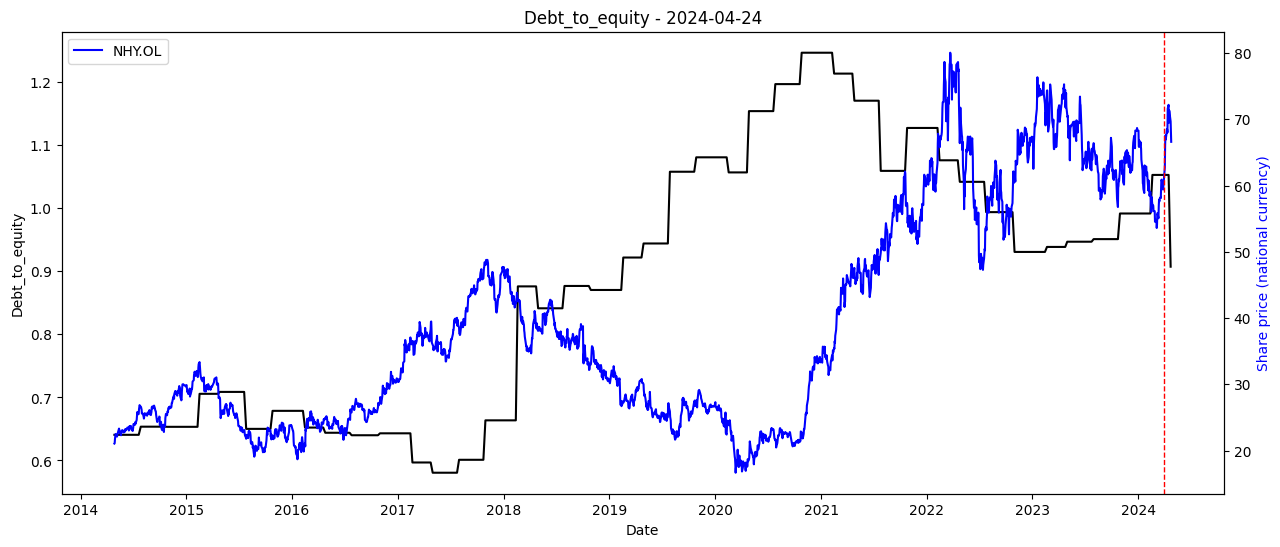

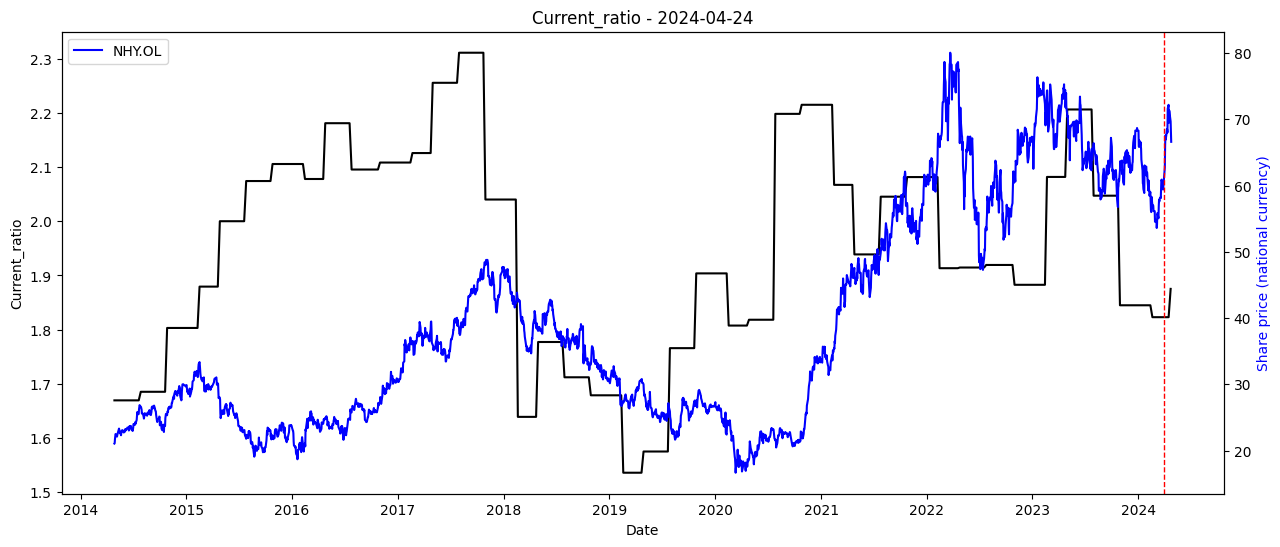

In [21]:
# plot value parameters in time and identify similar events
utils.get_historical_analouges(
    input_df=merged_nat_curr,
    ticker_all_price=ticker_all_price,
    share_name=share_name,
    tolerance=0.2,
    owned_shares=owned_shares
    )